# Clustering

In contrast to *supervised* machine learning, *unsupervised* learning is used when there is no "ground truth" from which to train and validate label predictions. The most common form of unsupervised learning is *clustering*, which is simllar conceptually to *classification*, except that the the training data does not include known values for the class label to be predicted. Clustering works by separating the training cases based on similarities that can be determined from their feature values. Think of it this way; the numeric features of a given entity can be though of as vector coordinates that define the entity's position in n-dimensional space. What a clustering model seeks to do is to identify groups, or *clusters*, of entities that are close to one another while being separated from other clusters.

For example, let's take a look at the Palmer Islands penguin dataset, which contains measurements of penguins.

Let's start by examining a dataset that contains observations of multiple classes. We'll use a dataset that contains observations of three different species of penguin.

> **Citation**: The penguins dataset used in the this exercise is a subset of data collected and made available by [Dr. Kristen
Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php)
and the [Palmer Station, Antarctica LTER](https://pal.lternet.edu/), a
member of the [Long Term Ecological Research
Network](https://lternet.edu/).

In [26]:
import pandas as pd

# load the training dataset (dropping rows with nulls)
penguins = pd.read_csv('data/penguins.csv').dropna()

# Display a random sample of 10 observations (just the features)
penguin_features = penguins[penguins.columns[0:4]]
penguin_features.sample(10)

# penguins.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
4,36.7,19.3,193.0,3450.0,0
5,39.3,20.6,190.0,3650.0,0


As you can see, the dataset contains four data points (or *features*) for each instance (*observation*) of an penguin. So you could interpret these as coordinates that describe each instance's location in four-dimensional space.

Now, of course four dimensional space is difficult to visualise in a three-dimensional world, or on a two-dimensional plot; so we'll take advantage of a mathematical technique called *Principal Component Analysis* (PCA) to analyze the relationships between the features and summarize each observation as coordinates for two principal components - in other words, we'll translate the four dimensional feature values into two-dimensional coordinates.

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Normalize the numeric features so they're on the same scale
penguin_features[penguins.columns[0:4]] = MinMaxScaler().fit_transform(penguin_features[penguins.columns[0:4]])



# Get two principal components
pca = PCA(n_components=2).fit(penguin_features.values)
penguins_2d = pca.transform(penguin_features.values)
penguins_2d[0:10]

<ipython-input-13-ea3b7f3a9135>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguin_features[penguins.columns[0:4]] = MinMaxScaler().fit_transform(penguin_features[penguins.columns[0:4]])
C:\Users\aryan\Anaconda3\envs\azureml\lib\site-packages\pandas\core\frame.py:3072: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
C:\Users\aryan\Anaconda3\envs\azureml\lib\site-packages\pandas\core\frame.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the c

array([[-0.42106032,  0.00303797],
       [-0.28822919, -0.10630972],
       [-0.2980564 , -0.0474408 ],
       [-0.4061154 ,  0.02199611],
       [-0.43967918,  0.20457649],
       [-0.39540885, -0.09660671],
       [-0.18312462,  0.17063491],
       [-0.37508936, -0.14328578],
       [-0.29175883,  0.2489866 ],
       [-0.37079512, -0.19567099]])

Now that we have the data points translated to two dimensions, we can visualize them in a plot:

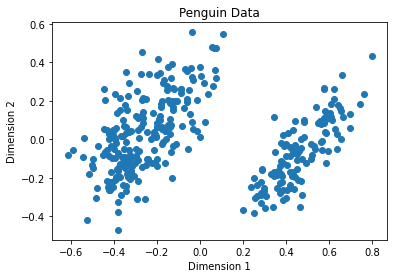

In [40]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(penguins_2d[:,0],penguins_2d[:,1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Penguin Data')

plt.show()

Hopefully you can see at least two, arguably three, reasonably distinct groups of data points; but here lies one of the fundamental problems with clustering - without known class labels, how do you know how many clusters to separate your data into?

One way we can try to find out is to use a data sample to create a series of clustering models with an incrementing number of clusters, and measure how tightly the data points are grouped within each cluster. A metric often used to measure this tightness is the *within cluster sum of squares* (WCSS), with lower values meaning that the data points are closer. You can then plot the WCSS for each model.

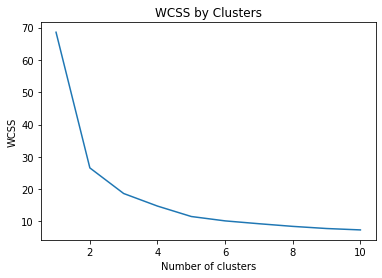

In [15]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

# Create 10 models with 1 to 10 clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i)
    # Fit the Iris data points
    kmeans.fit(penguin_features.values)
    # Get the WCSS (inertia) value
    wcss.append(kmeans.inertia_)
    
#Plot the WCSS values onto a line graph
plt.plot(range(1, 11), wcss)
plt.title('WCSS by Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The plot shows a large reduction in WCSS (so greater *tightness*) as the number of clusters increases from one to two, and a further noticable reduction from two to three clusters. After that, the reduction is less pronounced, resulting in an "elbow" in the chart at around three clusters. This is a good indication that there are two to three reasonably well separated clusters of data points.

## K-Means Clustering

The algorithm we used to create our test clusters is *K-Means*. This is a commonly used clustering algorithm that separates a dataset into *K* clusters of equal variance. The number of clusters, *K*, is user defined. The basic algorithm has the following steps:

1. A set of K centroids are randomly chosen.
2. Clusters are formed by assigning the data points to their closest centroid.
3. The means of each cluster is computed and the centroid is moved to the mean.
4. Steps 2 and 3 are repeated until a stopping criteria is met. Typically, the algorithm terminates when each new iteration results in negligable movement of centroids and the clusters become static.
5. When the clusters stop changing, the algorithm has *converged*, defining the locations of the clusters - note that the random starting point for the centroids means that re-running the algorithm could result in slightly different clusters, so training usually involves multiple iterations, reinitializing the centroids each time, and the model with the best WCSS is selected.

Let's try using K-Means on our iris data with a K value of 3.

In [24]:
from sklearn.cluster import KMeans

# Create a model based on 3 centroids
model = KMeans(n_clusters=3, init='k-means++', n_init=20, max_iter=200)
# Fit to the iris data and predict the cluster assignments for each data point
km_clusters = model.fit_predict(penguin_features.values)
# View the cluster assignments
km_clusters

array([2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1,

Let's see those cluster assignments with the two-dimensional iris data points.

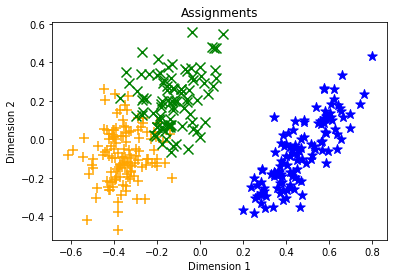

In [25]:
def plot_clusters(samples, clusters):
    col_dic = {0:'blue',1:'green',2:'orange',3:'red'}
    mrk_dic = {0:'*',1:'x',2:'+',3:'p'}
    colors = [col_dic[x] for x in clusters]

    markers = [mrk_dic[x] for x in clusters]
    for sample in range(len(clusters)):
        plt.scatter(samples[sample][0], samples[sample][1], color = colors[sample], marker=markers[sample], s=100)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Assignments')
    plt.show()

plot_clusters(penguins_2d, km_clusters)

The clusters look reasonably well separated.

So what's the practical use of clustering? In some cases, you may have data that you need to group into distict clusters without knowing how many clusters there are or what they indicate. For example a marketing organization might want to separate customers into distinct segments, and then investigate how those segments exhibit different purchasing behaviors.

Sometimes, clustering is used as an initial step towards creating a classification model. You start by identifying distinct groups of data points, and then assign class labels to those clusters. You can then use this labelled data to train a classification model.

In the case of the penguin data, the different species of penguin are already known, so we can use the class labels identifying the species to plot the class assignments and compare them to the clusters identified by our unsupervised algorithm

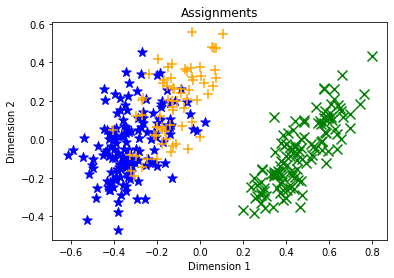

In [29]:
penguin_species = penguins[penguins.columns[4]]


plot_clusters(penguins_2d, penguin_species.values)

There may be some differences in the cluster assignments and class labels, but the K-Means model should have done a reasonable job of clustering the penguin observations so that birds of the same species are generally in the same cluster.

## Hierarchical Clustering

Hierarchical clustering methods make fewer distributional assumptions when compared to K-means methods. However, K-means methods are generally more scalable, sometimes very much so.

Hierarchical clustering creates clusters by either a *divisive* method or *agglomerative* method. The divisive method is a "top down" approach starting with the entire dataset and then finding partitions in a stepwise manner. Agglomerative clustering is a "bottom up** approach. In this lab you will work with agglomerative clustering which roughly works as follows:

1. The linkage distances between each of the data points is computed.
2. Points are clustered pairwise with their nearest neighbor.
3. Linkage distances between the clusters are computed.
4. Clusters are combined pairwise into larger clusters.
5. Steps 3 and 4 are repeated until all data points are in a single cluster.

The linkage function can be computed in a number of ways:
- Ward linkage measures the increase in variance for the clusters being linked,
- Average linkage uses the mean pairwise distance between the members of the two clusters,
- Complete or Maximal linkage uses the maximum distance between the members of the two clusters.

Several different distance metrics are used to compute linkage functions:
- Euclidian or l2 distance is the most widely used. This metric is only choice for the Ward linkage method.
- Manhattan or l1 distance is robust to outliers and has other interesting properties.
- Cosine similarity, is the dot product between the location vectors divided by the magnitudes of the vectors. Notice that this metric is a measure of similarity, whereas the other two metrics are measures of difference. Similarity can be quite useful when working with data such as images or text documents.

### Agglomerative Clustering

Let's see an example of clustering the iris data using an agglomerative clustering algorithm.

In [37]:
from sklearn.cluster import AgglomerativeClustering

# agg_model = AgglomerativeClustering(n_clusters=3,affinity='manhattan',linkage='average')
agg_model = AgglomerativeClustering(n_clusters=3,affinity='manhattan',linkage='average')
agg_clusters = agg_model.fit_predict(penguin_features.values)
agg_clusters

array([1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2,
       0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 0, 2, 2, 2, 2,
       2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 0, 2, 1,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2,
       0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,

So what do the agglomerative cluster assignments look like?

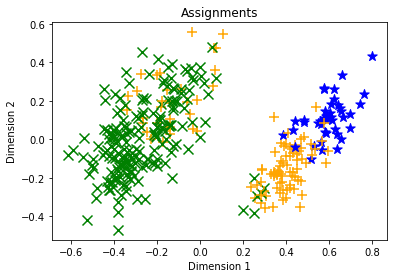

In [38]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_clusters(samples, clusters):
    col_dic = {0:'blue',1:'green',2:'orange'}
    mrk_dic = {0:'*',1:'x',2:'+'}
    colors = [col_dic[x] for x in clusters]
    markers = [mrk_dic[x] for x in clusters]
    for sample in range(len(clusters)):
        plt.scatter(samples[sample][0], samples[sample][1], color = colors[sample], marker=markers[sample], s=100)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Assignments')
    plt.show()

plot_clusters(penguins_2d, agg_clusters)


In this notebook, you've explored clustering; an unsupervised form of machine learning.

To learn more about clustering with scikit-learn, see the [scikit-learn documentation](https://scikit-learn.org/stable/modules/clustering.html).